<a href="https://colab.research.google.com/github/dundurlunka/ml-grand-slam/blob/main/ml_grand_slam-final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Read data from github

In [3]:
import pandas as pd
import numpy as np

import sys
import csv

In [ ]:
csv.field_size_limit(sys.maxsize)

points = pd.read_csv('./charting-m-points-from-2017.csv', quoting=csv.QUOTE_NONE, encoding = 'ISO-8859-1')
matches = pd.read_csv('./charting-m-matches.csv', quoting=csv.QUOTE_NONE, encoding = 'ISO-8859-1')

Merge the two datasets together by match_id

In [ ]:
joinedData = pd.merge(
    matches,
    points,
    how="inner",
    on='match_id',
)

In [ ]:
df_obj = joinedData.select_dtypes(['object'])
joinedData[df_obj.columns] = df_obj.apply(lambda x: x.str.strip())

Select relevant columns from dataframe


In [ ]:
joinedData.columns = joinedData.columns.to_series().apply(lambda x: x.strip())
joinedData = joinedData.loc[:, ['Player 1', 'Player 2', 'Tournament', 'Pl 1 hand', 'Pl 2 hand', 'Surface', 'Set1','Set2', 'Gm1', 'Gm2', 'Pts', 'Serving', '1st', '2nd', 'isAce', 'isUnret']]

In [ ]:
joinedData['isAce'] = joinedData['isAce'] | joinedData['isUnret']
joinedData = joinedData.drop(columns=['isUnret', 'isAce'])

In [ ]:
tennis_players = ['Daniil Medvedev', 'Alexander Zverev', 'Roger Federer', 'Dominic Thiem', 'Nick Kyrgios', 'Novak Djokovic', 'Rafael Nadal', 'Stefanos Tsitsipas', 'Casper Ruud', 'Grigor Dimitrov']
tennis_players_initials = [''.join([x[0].upper() for x in fullname.split(' ')]) for fullname in tennis_players]
joinedData = joinedData.loc[((joinedData['Player 1'].isin(tennis_players)) | (joinedData['Player 2'].isin(tennis_players)))]
joinedData = joinedData.loc[joinedData['Serving'].isin(tennis_players_initials)]

In [ ]:
joinedData[['Pts1', 'Pts2']] = joinedData['Pts'].str.split('-', expand=True)
joinedData = joinedData.drop('Pts', axis='columns')

Separate the columns into new columns that are specific for Server and Returner.

In [ ]:
server_names = []
returner_names = []
pointsServer = []
pointsReturner = []
gamesServer = []
gamesReturner = []
setsServer = []
setsReturner = []
handReturner = []
for index, row in joinedData.iterrows():
    if ''.join([x[0].upper() for x in row['Player 1'].split(' ')]) == row['Serving']:
      server_names.append(row['Player 1'])
      returner_names.append(row['Player 2'])
      pointsServer.append(row['Pts1'])
      pointsReturner.append(row['Pts2'])
      gamesServer.append(row['Gm1'])
      gamesReturner.append(row['Gm2'])
      setsServer.append(row['Set1'])
      setsReturner.append(row['Set2'])
      handReturner.append(row['Pl 2 hand'])
    elif ''.join([x[0].upper() for x in row['Player 2'].split(' ')]) == row['Serving']:
      server_names.append(row['Player 2'])
      returner_names.append(row['Player 1'])
      pointsServer.append(row['Pts2'])
      pointsReturner.append(row['Pts1'])
      gamesServer.append(row['Gm2'])
      gamesReturner.append(row['Gm1'])
      setsServer.append(row['Set2'])
      setsReturner.append(row['Set1'])
      handReturner.append(row['Pl 1 hand'])

joinedData['FullNameServer'] = server_names
joinedData['FullNameReturner'] = returner_names
joinedData['PointsServer'] = pointsServer
joinedData['PointsReturner'] = pointsReturner
joinedData['GamesServer'] = gamesServer
joinedData['GamesReturner'] = gamesReturner
joinedData['SetsServer'] = setsServer
joinedData['SetsReturner'] = setsReturner
joinedData['HandReturner'] = handReturner

joinedData = joinedData.drop(columns=['Player 1', 'Player 2', 'Pts1', 'Pts2', 'Gm1', 'Gm2', 'Set1', 'Set2', 'Pl 1 hand', 'Pl 2 hand', 'Serving'])

Combine the serves into one column with a list of 1 or 2 serves so that it can be exploded into several rows later

In [ ]:
joinedData['Serves'] = joinedData.apply(lambda x: list(['f' + str(x['1st']),
                                                        's' + str(x['2nd'])]), axis=1)   

Explode list of first and second serve into separate rows

In [ ]:
joinedData = joinedData.explode('Serves')

Add new column indicating whether the serve was first or second

In [ ]:
joinedData['IsFirstServe'] = joinedData['Serves'].str[0] == 'f'

Remove 'f' and 's' (first and second serve) that were indicators before the explosion

In [ ]:
joinedData['Serves'] = joinedData['Serves'].str[1:]
joinedData = joinedData[(joinedData['Serves'] != 'nan') & (joinedData['Serves'] != '')]
joinedData = joinedData.drop(columns=['1st', '2nd'])

Remove lets

In [ ]:
joinedData['Serves'] = joinedData['Serves'].map(lambda x: x.lstrip('c'))

In [ ]:
joinedData['FullNameServer'].value_counts()
joinedData['FullNameReturner'].value_counts()

Extract direction of serve

In [ ]:
def extract_serve_direction(row):
  serves_directions_dict = {
      '4': 'Out wide',
      '5': 'Body',
      '6': 'Down the T'
  }

  if len(row['Serves']) > 1 and row['Serves'][1] in ['x', 'd', 'w', 'n', 'g', '!', 'e']:
      return "Fault"
  else:
      return serves_directions_dict.get(row['Serves'][0], 'Body')

joinedData['Direction'] = joinedData.apply(extract_serve_direction, axis=1)
joinedData = joinedData.drop(columns='Serves')

In [ ]:
joinedData.to_csv('wrangled-data.csv')

# Start of machine learning

### Data exploration

In [1]:
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

In [50]:
joinedData = pd.read_csv('./wrangled-data.csv')
joinedData = joinedData.drop(columns=['Unnamed: 0'])

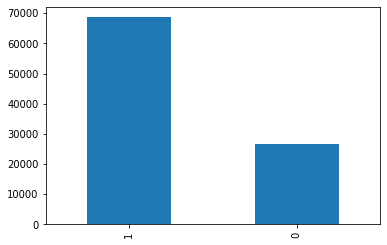

In [51]:
joinedData['Direction'].value_counts().plot(kind='bar')

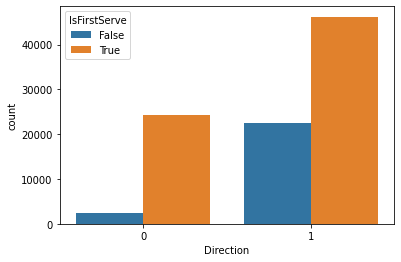

In [52]:
sns.countplot(
    x = 'Direction',
    hue = 'IsFirstServe',
    data = joinedData,
)

## Pre-processing

In [53]:
X = joinedData.drop(columns=['Direction'])
y = joinedData['Direction']

### One hot encoding attributes

In [54]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer

categorical_columns = ['Surface', 'FullNameServer', 'FullNameReturner', 'PointsServer', 'PointsReturner', 'HandReturner', 'Tournament']

encoded_X = pd.get_dummies(X, columns=categorical_columns)

In [ ]:
encoded_X.to_csv('encoded_attributes.csv')

### Label encoding the label

In [55]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
encoded_y = le.fit_transform(y)

Това го използвахме, когато се опитвахме да предсказваме повече от 2 класа. Тук всъщност правим енкодинг на посоката на сервиса.

### Splitting into train test

In [56]:
X_train, X_test, y_train, y_test = train_test_split(encoded_X, encoded_y)

## KNN

In [115]:
def plot_knn_scores(ks):
    train_scores = []
    test_scores = []
    
    for k in ks:
        clf = KNeighborsClassifier(n_neighbors=k).fit(X_train, y_train)

        print('finding scores for ' + str(k) + ' k nearest neighbours')

        train_score = clf.score(X_train, y_train)
        test_score = clf.score(X_test, y_test)              

        print('found scores for ' + str(k) + ' k nearest neighbours\n' + f'train_score: {train_score}\n' + f'test_score: {test_score}')

        train_scores.append(train_score)
        test_scores.append(test_score)

    plt.figure(figsize=(10, 6))
    plt.plot(ks, train_scores, color='blue', label='train score')
    plt.plot(ks, test_scores, color='green', label='test score')
    plt.legend()

In [ ]:
plot_knn_scores(range(1, 15, 2))

finding scores for 1 k nearest neighbours


## Logistic regression

In [ ]:
from pandas import read_csv
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV

# define model
model = LogisticRegression()

# define evaluation
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

# define search space
space = dict()
space['penalty'] = ['none', 'l1', 'l2']
space['C'] = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100]

# define search
search = GridSearchCV(model, space, scoring='accuracy', n_jobs=-1, cv=cv)

# execute search
result = search.fit(X_train, y_train)

# summarize result
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Scoring for different class weights')

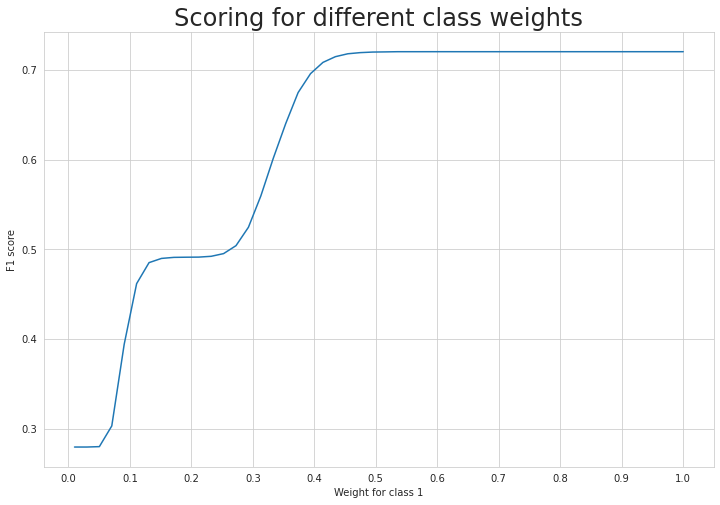

In [92]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
lr = LogisticRegression(penalty='l2')

#Setting the range for class weights
weights = np.linspace(0.0,0.99,50)

#Creating a dictionary grid for grid search
param_grid = {'class_weight': [{0:x, 1:1.0-x} for x in weights]}

#Fitting grid search to the train data with 5 folds
gridsearch = GridSearchCV(estimator= lr, 
                          param_grid= param_grid,
                          cv=StratifiedKFold(), 
                          n_jobs=-1, 
                          scoring='accuracy', 
                          verbose=2).fit(X_train, y_train)

#Ploting the score for different values of weight
sns.set_style('whitegrid')
plt.figure(figsize=(12,8))
weigh_data = pd.DataFrame({ 'score': gridsearch.cv_results_['mean_test_score'], 'weight': (1- weights)})
sns.lineplot(weigh_data['weight'], weigh_data['score'])
plt.xlabel('Weight for class 1')
plt.ylabel('F1 score') # ACCURACY !!!
plt.xticks([round(i/10,1) for i in range(0,11,1)])
plt.title('Scoring for different class weights', fontsize=24)

In [109]:
from sklearn.linear_model import LogisticRegression

train_scores = []
test_scores = []

# 1e-7 1e-6, 1e-5, 1e-4, 1e-3
regression = LogisticRegression(class_weight = "balanced", penalty='l2', max_iter=50).fit(X_train, y_train)

train_score = regression.score(X_train, y_train)
test_score = regression.score(X_test, y_test)

print(f'found train score: {train_score}')

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


found train score: 0.5104468421568216


In [110]:
from sklearn import metrics

y_pred = regression.predict(X_test)
print(f"F1 Score: {metrics.f1_score(y_test, y_pred)}")

print("Accuracy:",metrics.accuracy_score(y_test, y_pred)) 

print("Precision:",metrics.precision_score(y_test, y_pred)) 

print("Recall:",metrics.recall_score(y_test, y_pred)) 

F1 Score: 0.5122835943940643
Accuracy: 0.5032537050253999
Precision: 0.869577385950182
Recall: 0.3630945424798411


/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


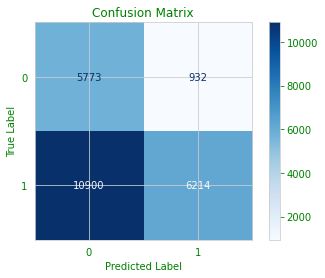

In [111]:
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix
 
color = 'green'
matrix = plot_confusion_matrix(regression, X_test, y_test, cmap=plt.cm.Blues)
matrix.ax_.set_title('Confusion Matrix', color=color)
plt.xlabel('Predicted Label', color=color)
plt.ylabel('True Label', color=color)
plt.gcf().axes[0].tick_params(colors=color)
plt.gcf().axes[1].tick_params(colors=color)
plt.show()


## Изводи

Първоначално се опитахме да класифицираме 4 класа - 3 за посока и 1 за аут. Пробвахме паралелно с KNN и с логистична регресия, като и двата модела връщаха сходни резултати за точност. Сходните резултати всъщност бяха процентът на представителност на класа с най-много данни. Още тогава пробвахме да дадем доста ниска стойност на C параметъра на логистичната регресия, за да се справим с това, но не пожънахме успех.

След тези наблюдения преминахме към това да предсказваме само 3 класа - 3-те посоки без аут. Отново и двата модела връщаха същата точност, т.е. представителността на класа с най-много данни. Тогава вече решихме да пуснем и GridSearch, с който да си оптимизираме параметрите на логистичната регресия. GridSearch-ът потвърди решението ни за ниска стойност на C параметъра и това, че използваме L2 регуляризация.

Тук вече се смирихме и решихме да предсказваме само 2 класа - дали сервисът е успешен или неуспешен. Директно пуснахме GridSearch, който да ни даде най-добрите C параметър, вид на регуляризацията и тежести на класовете. Тук всъщност научихме, че можем да регулираме тежестите на класовете заради небалансираността на данните - успешните сервиси представляваха ок. 70% от данните. Въртяхме доста тежести, като най-успешните всъщност ни даваха отново 70% точност, т.е. пак само първия клас.

Решихме да пуснем GridSearch с фиксирани C параметър и L2 регуляризация и само да видим най-добрите тежести. И тук се потвърдиха опасенията ни, че явно данните ни не са такива каквито искахме да бъдат, т.е. изглежда, че това как ще бие един тенисист своя сервис изцяло лежи на неговия стил на игра и стратегията му спрямо конкретния мач.

Като бъдеща идея - би могло да се изпробва да се предсказва сервис на играч в конкретен мач. Идеята е да се следи някаква последователност от предходните му сервиси и техните изходи и оттам по някакъв начин да се заключи какъв би могъл да бъде следващият му.